In [1]:
# A simple example to get started using GUIDE
import os
import pandas as pd

from scipy.sparse import hstack, csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import numpy as np
import matplotlib.pyplot as plt

In [2]:
le_cat_columns = [
    "Category",
    "EntityType",
    "EvidenceRole",
    "SuspicionLevel",
    "LastVerdict",
    "ResourceType",
    "Roles",
    "AntispamDirection",
    "ThreatFamily",
    "CountryCode",
    "OSFamily",
    "OSVersion",
    "State",
    "City",
    "RegistryValueName",
    "RegistryValueData",
    "ResourceIdName",
    "RegistryKey",
    "OAuthApplicationId",
    "ApplicationId",
    "ApplicationName",
]

numerical_columns = [
    "DeviceId",
    "Sha256",
    "IpAddress",
    "Url",
    "AccountSid",
    "AccountUpn",
    "AccountObjectId",
    "AccountName",
    "DeviceName",
    "NetworkMessageId",
    "EmailClusterId",
    "FileName",
    "FolderPath",
]
le_cat_columns += numerical_columns

numerical_columns = []

ohe_cat_columns = []

In [3]:
def preprocess_data(df, le_cat_columns):

    # Converts columns with fewer than 20 unique values to ohe categorical columns
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])

    # Converts numerical to label encoded categorical columns
    for le_col in le_cat_columns:
        df[le_col] = df[le_col].astype("object")

    return df

In [4]:
train = pd.read_csv("GUIDE_Train.csv")
test = pd.read_csv("GUIDE_Test.csv")

C:\Users\91894\AppData\Local\Temp\ipykernel_17808\2226568637.py:2: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv("GUIDE_Test.csv")


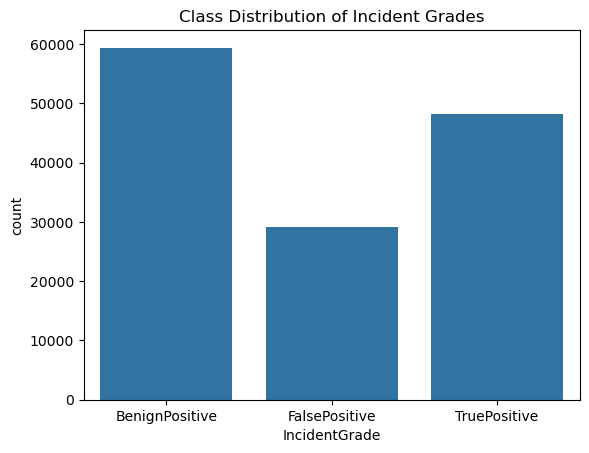

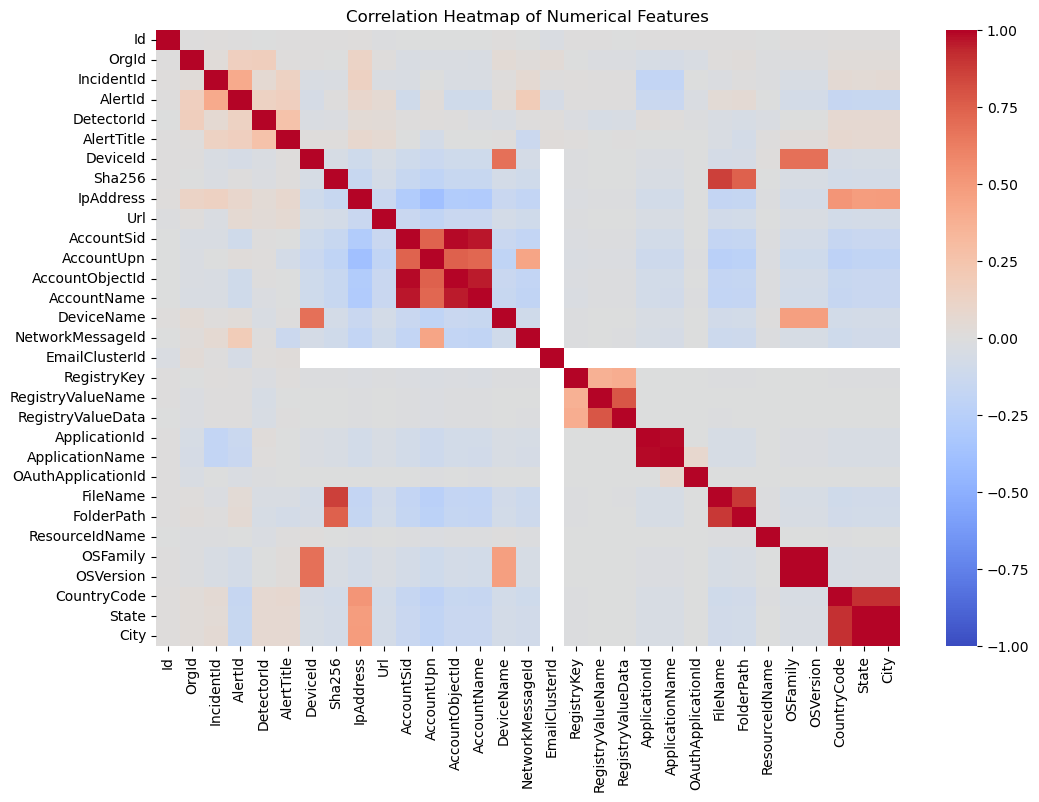

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample the data (e.g., 10% of the data)
sample_df = train.sample(frac=0.1, random_state=42)

# Check class distribution (for example, IncidentGrade)
sns.countplot(x='IncidentGrade', data=sample_df)
plt.title('Class Distribution of Incident Grades')
plt.show()

# Plot correlation heatmap for numerical features
numerical_columns = sample_df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(12, 8))
correlation_matrix = sample_df[numerical_columns].corr()

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


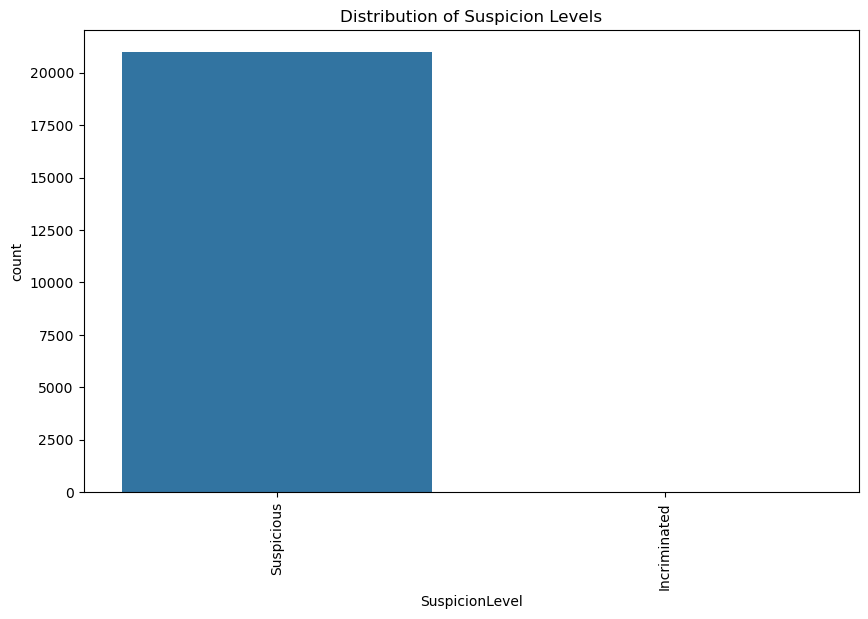

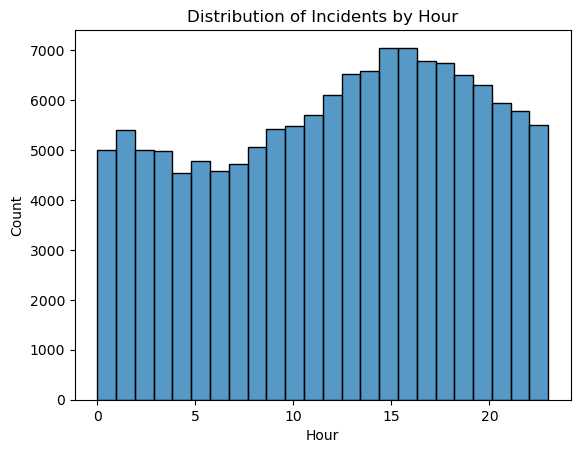

In [6]:
# Plot the distribution of 'SuspicionLevel'
plt.figure(figsize=(10, 6))
sns.countplot(x='SuspicionLevel', data=sample_df)
plt.title('Distribution of Suspicion Levels')
plt.xticks(rotation=90)
plt.show()

# Distribution of 'Timestamp' (after conversion to datetime)
sample_df['Timestamp'] = pd.to_datetime(sample_df['Timestamp'])

sample_df['Hour'] = sample_df['Timestamp'].dt.hour
sns.histplot(sample_df['Hour'], bins=24)
plt.title('Distribution of Incidents by Hour')
plt.show()


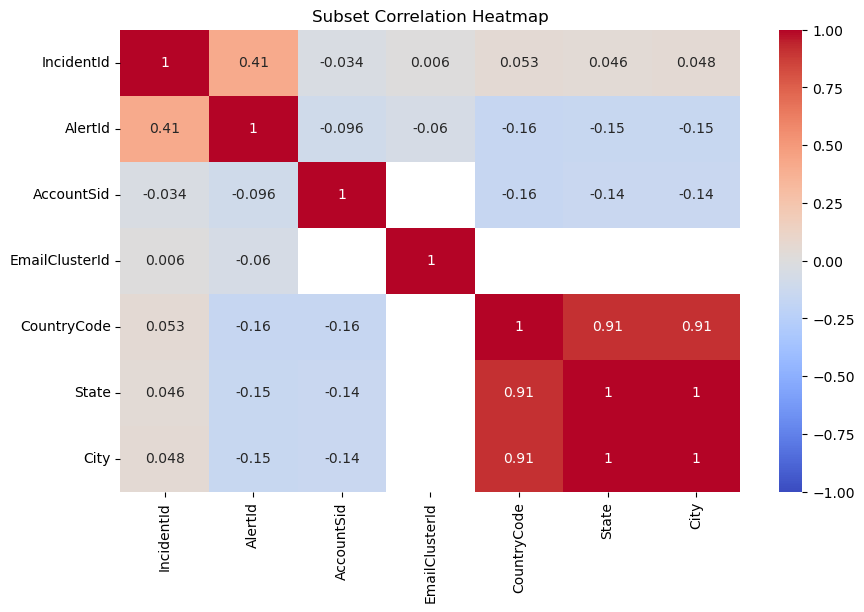

In [7]:
# Calculate correlation for a subset of columns
subset_columns = ['IncidentId', 'AlertId', 'AccountSid', 'EmailClusterId', 'CountryCode', 'State', 'City']

plt.figure(figsize=(10, 6))
subset_corr = sample_df[subset_columns].corr()

sns.heatmap(subset_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Subset Correlation Heatmap')
plt.show()


In [8]:
le_cat_columns = [
    "Category",
    "EntityType",
    "EvidenceRole",
    "SuspicionLevel",
    "LastVerdict",
    "ResourceType",
    "Roles",
    "AntispamDirection",
    "ThreatFamily",
    "CountryCode",
    "OSFamily",
    "OSVersion",
    "State",
    "City",
    "RegistryValueName",
    "RegistryValueData",
    "ResourceIdName",
    "RegistryKey",
    "OAuthApplicationId",
    "ApplicationId",
    "ApplicationName",
]

numerical_columns = [
    "DeviceId",
    "Sha256",
    "IpAddress",
    "Url",
    "AccountSid",
    "AccountUpn",
    "AccountObjectId",
    "AccountName",
    "DeviceName",
    "NetworkMessageId",
    "EmailClusterId",
    "FileName",
    "FolderPath",
]
le_cat_columns += numerical_columns

numerical_columns = []

ohe_cat_columns = []

In [9]:
def process_data(train_data, test_data):

    print(train_data.shape)

    # Drop rows with missing target variable 'IncidentGrade'
    train_data.dropna(subset=["IncidentGrade"], inplace=True)

    train_data = preprocess_data(train_data, le_cat_columns)
    test_data = preprocess_data(test_data, le_cat_columns)

    group_columns = ohe_cat_columns + numerical_columns + le_cat_columns

    # Drop duplicates based on the specified columns
    train_data = train_data.drop_duplicates(subset=group_columns)

    # Drop usage column as it is not present in train dataset
    test_data.drop(["Usage"], axis=1, inplace=True)

    print(train_data.shape)
    print(test_data.shape)

    #  One hot encoding
    ohe = OneHotEncoder(handle_unknown="ignore")
    ohe.fit(train_data[ohe_cat_columns])

    train_data_ohe = csr_matrix(ohe.transform(train_data[ohe_cat_columns]))
    test_data_ohe = csr_matrix(ohe.transform(test_data[ohe_cat_columns]))

    # Fill NaNs for numerical columns
    train_data_numerical = csr_matrix(train_data[numerical_columns].fillna(-1).values)
    test_data_numerical = csr_matrix(test_data[numerical_columns].fillna(-1).values)

    # Feature label encoding
    feature_le = LabelEncoder()

    train_data_le = pd.DataFrame()
    test_data_le = pd.DataFrame()

    # Fit and transform the feature variables
    for le_col in le_cat_columns:
        # we want to stack train and test for label encoding of some cat variables
        feature_le.fit(pd.concat([train_data[le_col], test_data[le_col]]))
        train_data_le[le_col] = feature_le.transform(train_data[le_col])
        test_data_le[le_col] = feature_le.transform(test_data[le_col])

    train_data_le = csr_matrix(train_data_le)
    test_data_le = csr_matrix(test_data_le)

    X_train = hstack([train_data_ohe, train_data_le, train_data_numerical])
    X_test = hstack([test_data_ohe, test_data_le, test_data_numerical])

    # Target label encoding
    target_le = LabelEncoder()

    # Fit and transform the target variable
    target_le.fit(train_data["IncidentGrade"])
    y_train = target_le.transform(train_data["IncidentGrade"])
    y_test = target_le.transform(test_data["IncidentGrade"])

    # Print out the label classes of the target variable
    """
        0: 'BenignPositive'
        1: 'FalsePositive'
        2: 'TruePositive'
    """
    print(f"Target Classes: {target_le.classes_}")

    return X_train, y_train, X_test, y_test

In [10]:
X_train, y_train, X_test, y_test = process_data(train, test)

(1374283, 45)
(591687, 45)
(4147992, 45)
Target Classes: ['BenignPositive' 'FalsePositive' 'TruePositive']


In [11]:
def train_random_forest_classifier(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)

    model.fit(X_train, y_train)

    # Feature importance
    importances = model.feature_importances_

    feature_columns = np.array(ohe_cat_columns + le_cat_columns + numerical_columns)

    # Plot feature importance
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances (Random Forest Classifier)")
    plt.bar(range(X_train.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train.shape[1]), feature_columns[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

    return model

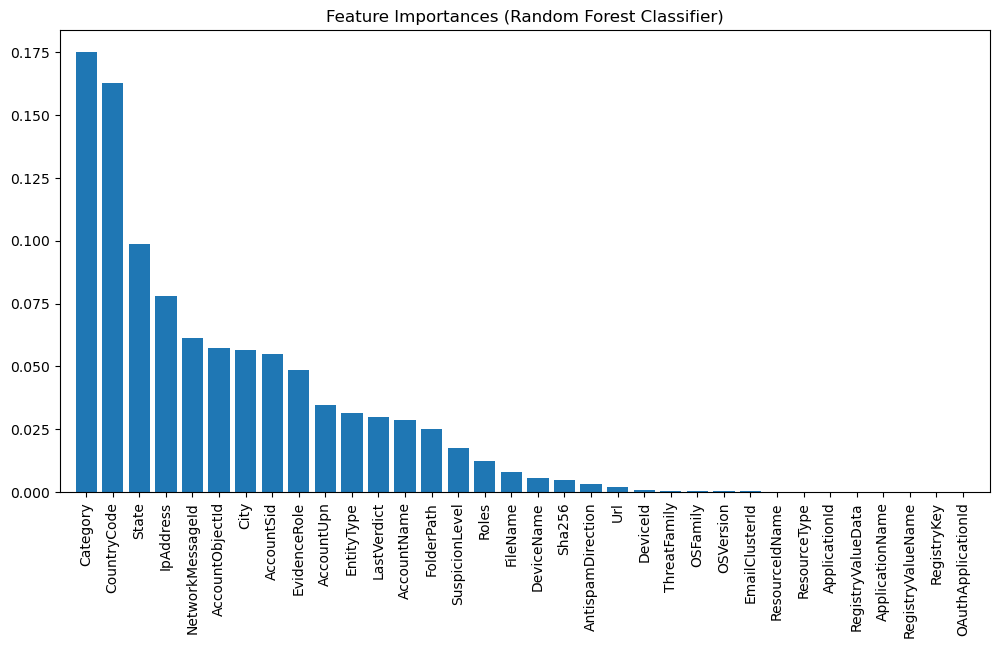

In [12]:
# train a random forest classifier model
rfc_model = train_random_forest_classifier(X_train, y_train)

In [13]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def predict(model, X_test, y_test):
    # Generate predictions
    y_pred = model.predict(X_test)
    y_prob = (
        model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred
    )

    # Print accuracy
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Print confusion matrix
    print("\nConfusion Matrix:")

    cm = confusion_matrix(y_test, y_pred)

    cm_display = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["BenignPositive", "FalsePositive", "TruePositive"],
    )

    cm_display.plot()
    plt.show()

    return y_pred

Accuracy: 0.5424

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.96      0.65   1752940
           1       0.74      0.03      0.06    902698
           2       0.79      0.36      0.50   1492354

    accuracy                           0.54   4147992
   macro avg       0.67      0.45      0.40   4147992
weighted avg       0.65      0.54      0.47   4147992


Confusion Matrix:


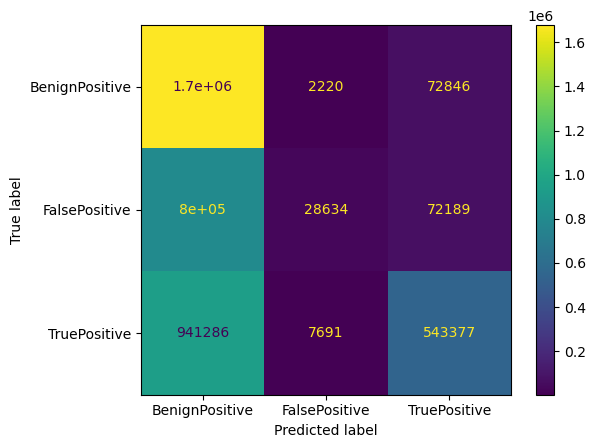

Accuracy: 0.5424034086854556
Macro-Precision: 0.6742164832625832
Macro-Recall: 0.4510016198883478
Macro-F1 Score: 0.40258701264413194


In [14]:
# make predictions
y_pred = predict(rfc_model, X_test, y_test)

# evaluate test performance
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average="macro")
precision = precision_score(y_test, y_pred, average="macro")

f1 = f1_score(y_test, y_pred, average="macro")

print("Accuracy: {}".format(accuracy))
print("Macro-Precision: {}".format(precision))
print("Macro-Recall: {}".format(recall))
print("Macro-F1 Score: {}".format(f1))

In [18]:
from xgboost import XGBClassifier


def train_xgboost_classifier(X_train, y_train):
    model = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        random_state=0,
        use_label_encoder=False,
        eval_metric="mlogloss",
        tree_method="hist"
    )

    model.fit(X_train, y_train)

    # Feature importance
    importances = model.feature_importances_

    feature_columns = np.array(ohe_cat_columns + le_cat_columns + numerical_columns)

    # Plot feature importance
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances (XGBoost Classifier)")
    plt.bar(range(X_train.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train.shape[1]), feature_columns[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

    return model

C:\Users\91894\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


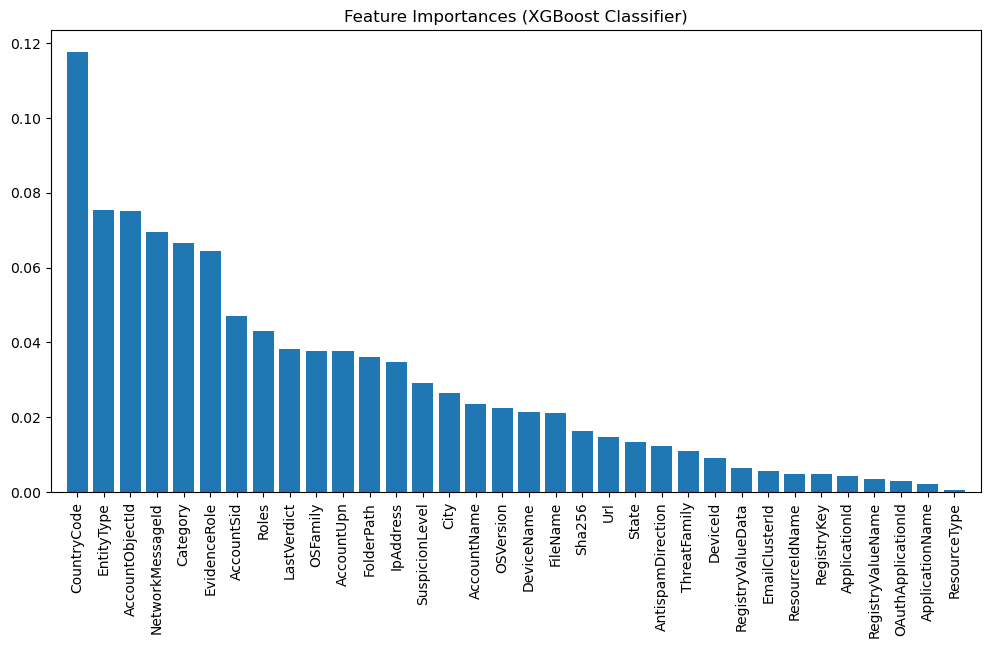

In [20]:
# train a random forest classifier model
xgb_model = train_xgboost_classifier(X_train, y_train)

Accuracy: 0.6104

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.94      0.68   1752940
           1       0.77      0.27      0.40    902698
           2       0.84      0.43      0.57   1492354

    accuracy                           0.61   4147992
   macro avg       0.72      0.55      0.55   4147992
weighted avg       0.70      0.61      0.58   4147992


Confusion Matrix:


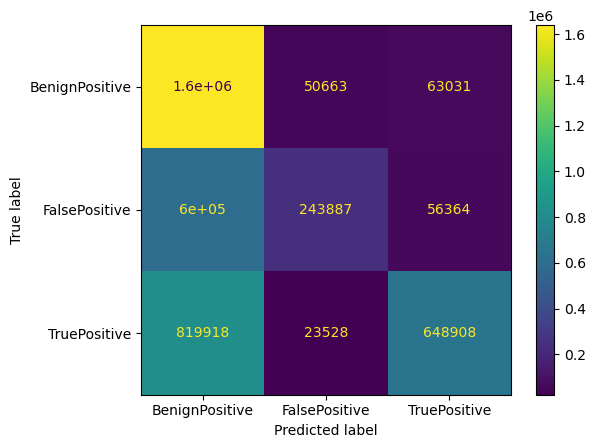

Accuracy: 0.6104257192395742
Macro-Precision: 0.7155902252774663
Macro-Recall: 0.5467127856832249
Macro-F1 Score: 0.5515344876604394


In [22]:
# make predictions
y_pred = predict(xgb_model, X_test, y_test)

# evaluate test performance
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average="macro")
precision = precision_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")

print("Accuracy: {}".format(accuracy))
print("Macro-Precision: {}".format(precision))
print("Macro-Recall: {}".format(recall))
print("Macro-F1 Score: {}".format(f1))

C:\Users\91894\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.4830

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.99      0.62   1752940
           1       0.57      0.03      0.06    902698
           2       0.90      0.16      0.27   1492354

    accuracy                           0.48   4147992
   macro avg       0.64      0.39      0.32   4147992
weighted avg       0.64      0.48      0.37   4147992


Confusion Matrix:


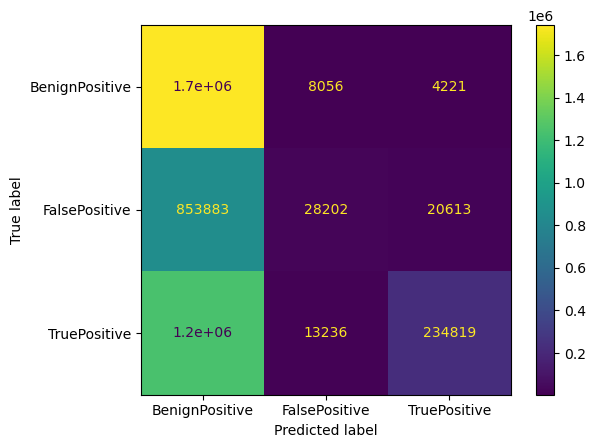


Logistic Regression Model Evaluation:
Accuracy: 0.4830491476357717
Macro-Precision: 0.6425324835386631
Macro-Recall: 0.39386209745125184
Macro-F1 Score: 0.3166239194617832


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Train Logistic Regression Model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = predict(lr_model, X_test, y_test)

# Evaluate test performance
accuracy_lr = accuracy_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr, average="macro")
precision_lr = precision_score(y_test, y_pred_lr, average="macro")
f1_lr = f1_score(y_test, y_pred_lr, average="macro")

print("\nLogistic Regression Model Evaluation:")
print("Accuracy: {}".format(accuracy_lr))
print("Macro-Precision: {}".format(precision_lr))
print("Macro-Recall: {}".format(recall_lr))
print("Macro-F1 Score: {}".format(f1_lr)) 

Accuracy: 0.7500

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78   1752940
           1       0.66      0.59      0.63    902698
           2       0.77      0.80      0.78   1492354

    accuracy                           0.75   4147992
   macro avg       0.73      0.73      0.73   4147992
weighted avg       0.75      0.75      0.75   4147992


Confusion Matrix:


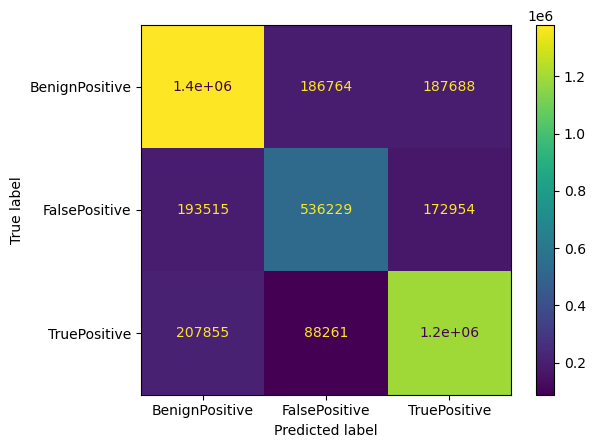


Decision Tree Model Evaluation:
Accuracy: 0.7499905978603623
Macro-Precision: 0.7346123309370852
Macro-Recall: 0.7273311472516197
Macro-F1 Score: 0.7302440619007178


In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Train Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = predict(dt_model, X_test, y_test)

# Evaluate test performance
accuracy_dt = accuracy_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt, average="macro")
precision_dt = precision_score(y_test, y_pred_dt, average="macro")
f1_dt = f1_score(y_test, y_pred_dt, average="macro")

print("\nDecision Tree Model Evaluation:")
print("Accuracy: {}".format(accuracy_dt))
print("Macro-Precision: {}".format(precision_dt))
print("Macro-Recall: {}".format(recall_dt))
print("Macro-F1 Score: {}".format(f1_dt))

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np
import gc

def train_decision_tree_classifier(X_train, y_train):
    # Convert data to float32 to reduce memory usage
    X_train = X_train.astype('float32')
    
    # Define the base model (Decision Tree)
    model = DecisionTreeClassifier(random_state=42)

    # Define the hyperparameters to tune
    param_grid = {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    }

    # Implement Grid Search with Cross Validation
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)

    # Fit the model with training data
    grid_search.fit(X_train, y_train)

    # Best model and hyperparameters
    best_model = grid_search.best_estimator_
    print("Best Hyperparameters:", grid_search.best_params_)

    # Clean up memory
    del grid_search, model, X_train
    gc.collect()

    return best_model

# Ensure that X_test and y_test are defined before proceeding
# X_test = ... # Your test features
# y_test = ... # Your test labels

# Convert X_test to float32 for consistency
X_test = X_test.astype('float32')

# Train the Decision Tree classifier with Grid Search
dt_model = train_decision_tree_classifier(X_train, y_train)

# Make predictions on the test set
y_pred = dt_model.predict(X_test)

# Evaluate test performance
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average="macro")
precision = precision_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")

print("\nDecision Tree Model Evaluation:")
print("Accuracy: {}".format(accuracy))
print("Macro-Precision: {}".format(precision))
print("Macro-Recall: {}".format(recall))
print("Macro-F1 Score: {}".format(f1))

# Clean up memory after predictions
del dt_model, X_test
gc.collect()

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10}

Decision Tree Model Evaluation:
Accuracy: 0.6522929648851782
Macro-Precision: 0.6705970666451316
Macro-Recall: 0.6249869177027919
Macro-F1 Score: 0.6341918243342705


0